## From our current EDA file - no need to add

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats as stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import statsmodels.api as sm

def drop_outliers(df, col):
    q1 = df[col].quantile(.25)
    q3 = df[col].quantile(.75)
    iqr = q3 - q1

    lower_lim = q1 - 1.5 * iqr
    upper_lim = q3 + 1.5 * iqr

    df = df.loc[ (df[col] >= lower_lim) & (df[col] <= upper_lim) ].reset_index(drop=True)
    return df

def scale_numberical_cols(df, cols_to_scale):
    df = df.copy()
    features = cols_to_scale
    autoscaler = StandardScaler()
    df[features] = autoscaler.fit_transform(df[features])
    return df

## Add in below

### EDA - Baseline OLS Model - v2 
#### Trying a new baseline model to get better model statistics.
- Just sqrt_foot living vs target of price

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

x = sm.add_constant(df[['sqft_living']])
y = df['price']
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                 1.773e+04
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:47:20   Log-Likelihood:            -4.4912e+05
No. Observations:               30155   AIC:                         8.982e+05
Df Residuals:                   30153   BIC:                         8.983e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.443e+04   9782.728     -7.609      0.000   -9.36e+04   -5.53e+04
sqft_living   560.0050      4.206    133.160      0.000     551.762     568.248
==============================================================================
Omnibus:                    43429.367   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         47159181.471
Skew:                           8.188   Prob(JB):                         0.00
Kurtosis:                     196.042   Cond. No.                     5.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Trying to see if address helps us**

In [3]:
df['address'][0]

'2102 Southeast 21st Court, Renton, Washington 98055, United States'

**Add in some new mapper functions to parse out some df columns**

In [4]:
# New Mapper functions for changing df values
def mapping_addressStreet(row):
    row = row.split(",")[0]
    row = row.split(" ")
    row = " ".join(row[1:])
    return row 

def mapping_addressCity(row):
    row = row.split(",")[-3].strip()
    return row 
    
def mapping_hasX(row):
    if row == 0:
        row = 0
    else:
        row = 1
    return row

In [5]:
# lets start from new baseline and play around with some new ideas on features 

df = drop_outliers(df, 'sqft_living').reset_index(drop=True)
df = drop_outliers(df, 'price').reset_index(drop=True)
df = df.dropna().reset_index(drop=True)


df['date_year'] = df['date'].apply(pd.to_datetime)
df['date_year'] = df['date_year'].dt.year
df['date_year']
df['age_when_sold'] = df['date_year'] - df['yr_built']
df['age_when_sold']

# Continuous numbers
#df['sqft_living']
df['sqft_lot_less_living'] = df['sqft_lot'] - (df['sqft_living']/df['floors'])

# Nominal categories
df['zipcode'] = df.address.str[-20:-15]
df['has_garage'] = df['sqft_garage'].map(mapping_hasX)
df['has_patio'] = df['sqft_patio'].map(mapping_hasX)
df['has_basement'] = df['sqft_basement'].map(mapping_hasX)
df['was_renovated'] = df['yr_renovated'].map(mapping_hasX)

df['waterfront']
df['street'] = df['address'].map(mapping_addressStreet)
df['city'] = df['address'].map(mapping_addressCity)

# Ordinal categories
df['grade']

# Scale the continous number features
df = scale_numberical_cols(df, ['sqft_living', 'age_when_sold', 'sqft_lot_less_living'])

# Baseline
x = sm.add_constant(df[['sqft_living']])
y = df['price']
model = sm.OLS(y, x).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]

r sqr: 0.29808815794081


Omnibus:,1234.082,Durbin-Watson:,2.006
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1454.890
Skew:,0.505,Prob(JB):,0.00
Kurtosis:,3.493,Cond. No.,1.00


**Check out the new features**

In [6]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,date_year,age_when_sold,sqft_lot_less_living,zipcode,has_garage,has_patio,has_basement,was_renovated,street,city
0,7399300360,5/24/2022,675000.0,4,1.0,-1.031441,7140,1.0,NO,NO,...,2022,0.184379,-0.147410,98055,0,1,0,0,Southeast 21st Court,Renton
1,8910500230,12/13/2021,920000.0,5,2.5,1.074642,6703,1.0,NO,NO,...,2021,0.748342,-0.186239,98133,0,1,1,0,Greenwood Avenue North,Seattle
2,1180000275,9/29/2021,311000.0,6,2.0,1.220346,6156,1.0,NO,NO,...,2021,0.560354,-0.198824,98178,0,0,1,0,South 113th Street,Seattle
3,1604601802,12/14/2021,775000.0,3,3.0,0.266648,1400,2.0,NO,NO,...,2021,-1.131536,-0.255448,98118,1,1,1,0,Letitia Avenue South,Seattle
4,8562780790,8/24/2021,592500.0,2,2.0,-1.110916,758,2.0,NO,NO,...,2021,-1.194199,-0.257785,98027,1,1,1,0,Northwest Talus Drive,Issaquah


**Make sure target is normalized after scaling**

<AxesSubplot:xlabel='price', ylabel='Count'>

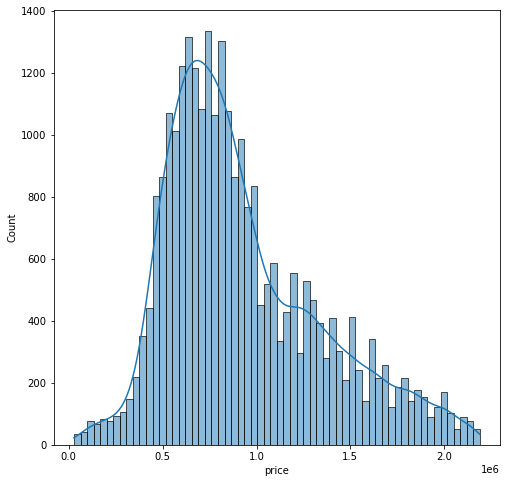

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(df.price, kde=True)

**Add in new feature 'sqft_lot_less_living', see what it does**

In [8]:
x = sm.add_constant(df[['sqft_living','sqft_lot_less_living']])    
y = df['price']
model = sm.OLS(y, x).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]

r sqr: 0.29833311693695685


Omnibus:,1223.273,Durbin-Watson:,2.006
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1439.380
Skew:,0.503,Prob(JB):,0.00
Kurtosis:,3.487,Cond. No.,1.09


**sqft lot helps jarque bera a tiny amount**

**Layer in 'age_when_sold' feature**

In [9]:
x = sm.add_constant(df[['sqft_living','sqft_lot_less_living', 'age_when_sold']])    
y = df['price']
model = sm.OLS(y, x).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]


r sqr: 0.3084343543426953


Omnibus:,1083.525,Durbin-Watson:,2.003
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1279.411
Skew:,0.460,Prob(JB):,1.51e-278
Kurtosis:,3.514,Cond. No.,1.37


**age_when_sold brings down Jarque-bera and omnibus**

**Try out new nominal categorical features using one hot encoder**

In [10]:
x = df[['sqft_living', 'sqft_lot_less_living','age_when_sold']]
ohe_cols = ['city']

ohe = OneHotEncoder(drop='first')
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),columns=ohe.get_feature_names())
X_cat = pd.concat([x,ohe_all], axis=1)
model = sm.OLS(y, sm.add_constant(X_cat)).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]

r sqr: 0.6086717457576551


Omnibus:,1758.096,Durbin-Watson:,1.990
Prob(Omnibus):,0.000,Jarque-Bera (JB):,7768.608
Skew:,0.126,Prob(JB):,0.00
Kurtosis:,5.582,Cond. No.,495.


**This worked out well. This is the new model to beat.**

**Try other features**

In [11]:
x = df[['sqft_living', 'sqft_lot_less_living','age_when_sold']]
ohe_cols = ['city','waterfront', 'has_basement', 'has_garage', 'has_patio']

ohe = OneHotEncoder(drop='first')
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),columns=ohe.get_feature_names())
X_cat = pd.concat([x,ohe_all], axis=1)
model = sm.OLS(y, sm.add_constant(X_cat)).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]

r sqr: 0.6145532644346619


Omnibus:,1763.972,Durbin-Watson:,1.991
Prob(Omnibus):,0.000,Jarque-Bera (JB):,8065.580
Skew:,0.097,Prob(JB):,0.00
Kurtosis:,5.637,Cond. No.,675.


**Try layering in a Ordinal Categorical variable (Grade)**

In [12]:
# ordinally encoding grade
grade_df = df[['grade']]
grade_cats = [['2 Substandard',
               '3 Poor',
               '4 Low',
               '5 Fair',
               '6 Low Average',
               '7 Average',
               '8 Good',
               '9 Better',
               '10 Very Good',
               '11 Excellent',
               '12 Luxury',
               '13 Mansion']]
ords_grade = OrdinalEncoder(categories=grade_cats)
ords_grade.fit(grade_df)
ords_grade.transform(grade_df)
grades_encoded = pd.DataFrame(ords_grade.transform(grade_df))


x=df[['sqft_living', 'sqft_lot_less_living', 'age_when_sold']]
ohe_cols = ['city','waterfront', 'has_basement', 'has_garage', 'has_patio']
ohe = OneHotEncoder(drop='first')

ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),
                            columns=ohe.get_feature_names())

X_cat = pd.concat([x,ohe_all,grades_encoded], axis=1)
model = sm.OLS(y, sm.add_constant(X_cat)).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]

r sqr: 0.6433191156817883


Omnibus:,2030.766,Durbin-Watson:,1.992
Prob(Omnibus):,0.000,Jarque-Bera (JB):,11104.832
Skew:,0.056,Prob(JB):,0.00
Kurtosis:,6.100,Cond. No.,2.47e+03


**This skyrockets our JB and our cond no. Not using Grade.**  

**Now try Condition**

In [13]:
# ordinally encoding condition
cond_df = df[['condition']]
cond_cats = [['Poor',
              'Fair',
              'Average',
              'Good',
              'Very Good']]
ords_cond = OrdinalEncoder(categories=cond_cats)
ords_cond.fit(cond_df)
ords_cond.transform(cond_df)
cond_encoded = pd.DataFrame(ords_cond.transform(cond_df))
cond_encoded

x=df[['sqft_living', 'sqft_lot_less_living', 'age_when_sold']]
ohe_cols = ['city','waterfront', 'has_basement', 'has_garage', 'has_patio']
ohe = OneHotEncoder(drop='first')

ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),
                            columns=ohe.get_feature_names())

X_cat = pd.concat([x,ohe_all,cond_encoded], axis=1)
model = sm.OLS(y, sm.add_constant(X_cat)).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]

r sqr: 0.6190943016797948


Omnibus:,1854.174,Durbin-Watson:,1.987
Prob(Omnibus):,0.000,Jarque-Bera (JB):,8735.570
Skew:,0.119,Prob(JB):,0.00
Kurtosis:,5.741,Cond. No.,1.27e+03


**This gives us a slightly better r squared (.619 vs .611 - our prior best), but it also doubles our condition and increases our JB by 1000.  We can call this Model B.**

**Need to discuss these and choose the best**

**Trying a couple more features - Starting from Model A**

In [14]:
x = df[['sqft_living', 'sqft_lot_less_living']]
ohe_cols = ['city','waterfront', 'has_basement', 'has_garage', 'has_patio','was_renovated']

ohe = OneHotEncoder(drop='first')
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),columns=ohe.get_feature_names())
X_cat = pd.concat([x,ohe_all], axis=1)
model = sm.OLS(y, sm.add_constant(X_cat)).fit()

s = model.summary();
print("R sqr:", model.rsquared)
s.tables[2]

R sqr: 0.6120600027616369


Omnibus:,1765.469,Durbin-Watson:,1.992
Prob(Omnibus):,0.000,Jarque-Bera (JB):,7810.138
Skew:,0.129,Prob(JB):,0.00
Kurtosis:,5.589,Cond. No.,673.


Didn't do much for us.  Try a few more

**Try all new and available nomimal categories**

In [16]:
x = df[['sqft_living', 'sqft_lot_less_living','age_when_sold']]
ohe_cols = ['city','waterfront', 'has_basement', 'has_garage', 'has_patio','greenbelt', 'nuisance', 'view']

ohe = OneHotEncoder(drop='first')
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),columns=ohe.get_feature_names())
X_cat = pd.concat([x,ohe_all], axis=1)
model = sm.OLS(y, sm.add_constant(X_cat)).fit()

s = model.summary()
print("R sqr:", model.rsquared)
s.tables[2]

R sqr: 0.6239080913151532


Omnibus:,1753.986,Durbin-Watson:,1.989
Prob(Omnibus):,0.000,Jarque-Bera (JB):,8235.209
Skew:,0.050,Prob(JB):,0.00
Kurtosis:,5.670,Cond. No.,777.


**Pretty good.  Not the best JB or Cond. No.**